In [1]:
import pandas as pd
import pyarrow.parquet as pq
import os

In [2]:
os.listdir("../data/vsb-power-line-fault-detection/")

['train.parquet',
 'test.parquet',
 'metadata_train.csv',
 'metadata_test.csv',
 'sample_submission.csv']

In [3]:
!du -sh ../data/vsb-power-line-fault-detection/*

260K	../data/vsb-power-line-fault-detection/metadata_test.csv
116K	../data/vsb-power-line-fault-detection/metadata_train.csv
160K	../data/vsb-power-line-fault-detection/sample_submission.csv
8.2G	../data/vsb-power-line-fault-detection/test.parquet
3.6G	../data/vsb-power-line-fault-detection/train.parquet


In [5]:
train = pq.read_pandas('../data/vsb-power-line-fault-detection/train.parquet').to_pandas()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 8712 entries, 0 to 8711
dtypes: int8(8712)
memory usage: 6.5 GB


In [44]:
del train

In [43]:
# each column is a signal
# first 6 signals
# aka first 2 measurements
subset_train = pq.read_pandas('../data/vsb-power-line-fault-detection/train.parquet', columns=[str(i) for i in range(6)]).to_pandas()

In [45]:
subset_train.head()

,0,1,2,3,4,5
0,18,1,-19,-16,-5,19
1,18,0,-19,-17,-6,19
2,17,-1,-20,-17,-6,19
3,18,1,-19,-16,-5,20
4,18,0,-19,-16,-5,20


In [11]:
train_meta = pd.read_csv("../data/vsb-power-line-fault-detection/metadata_train.csv")
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8712 entries, 0 to 8711
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   signal_id       8712 non-null   int64
 1   id_measurement  8712 non-null   int64
 2   phase           8712 non-null   int64
 3   target          8712 non-null   int64
dtypes: int64(4)
memory usage: 272.4 KB


In [12]:
train_meta.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [13]:
train_meta.target.value_counts()

0    8187
1     525
Name: target, dtype: int64

Each signal is 800000 measurements taken over 20 milliseconds. This is one cycle of the 50Hz power grid.

The sampling frequency $F_s$ is:

In [21]:
Fs = int(800000 / 20e-3)
Fs

40000000

Plot the three phase signals for the first measurement.

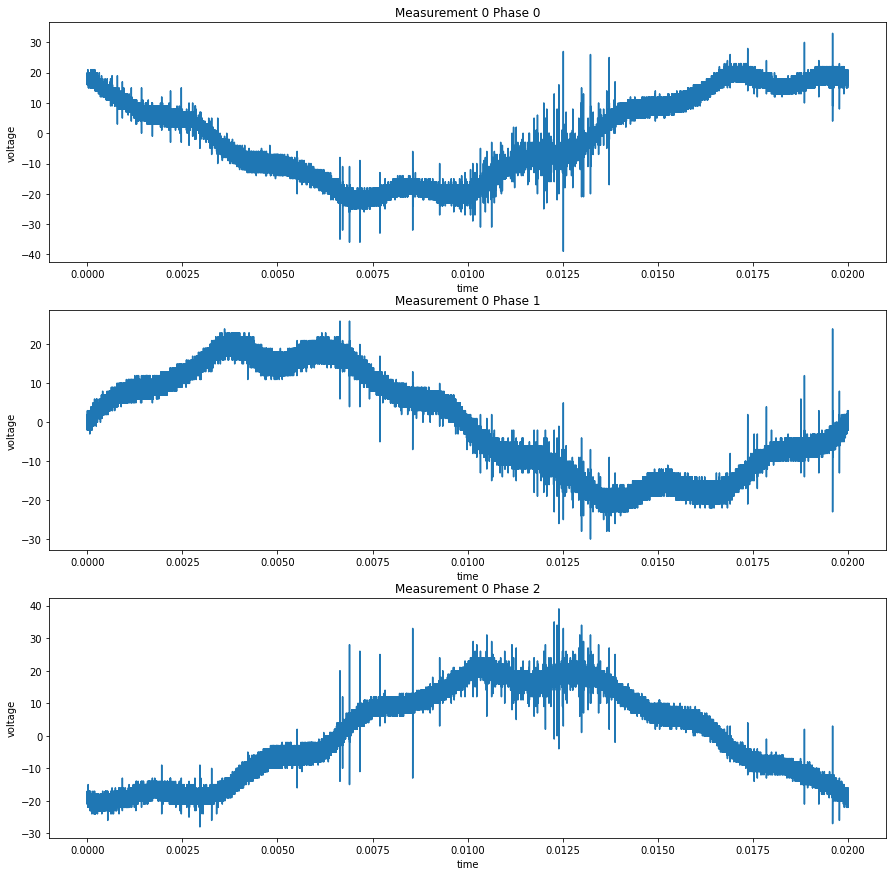

In [37]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0, 800000) * (1 / Fs)
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for i in range(0, 3):
    ax[i].plot(t, subset_train.iloc[:, i].values)
    ax[i].set_xlabel("time")
    ax[i].set_ylabel("voltage")
    phase = train_meta.loc[i, "phase"]
    measure_id = train_meta.loc[i, "id_measurement"]
    ax[i].set_title(f"Measurement {measure_id} Phase {phase}")

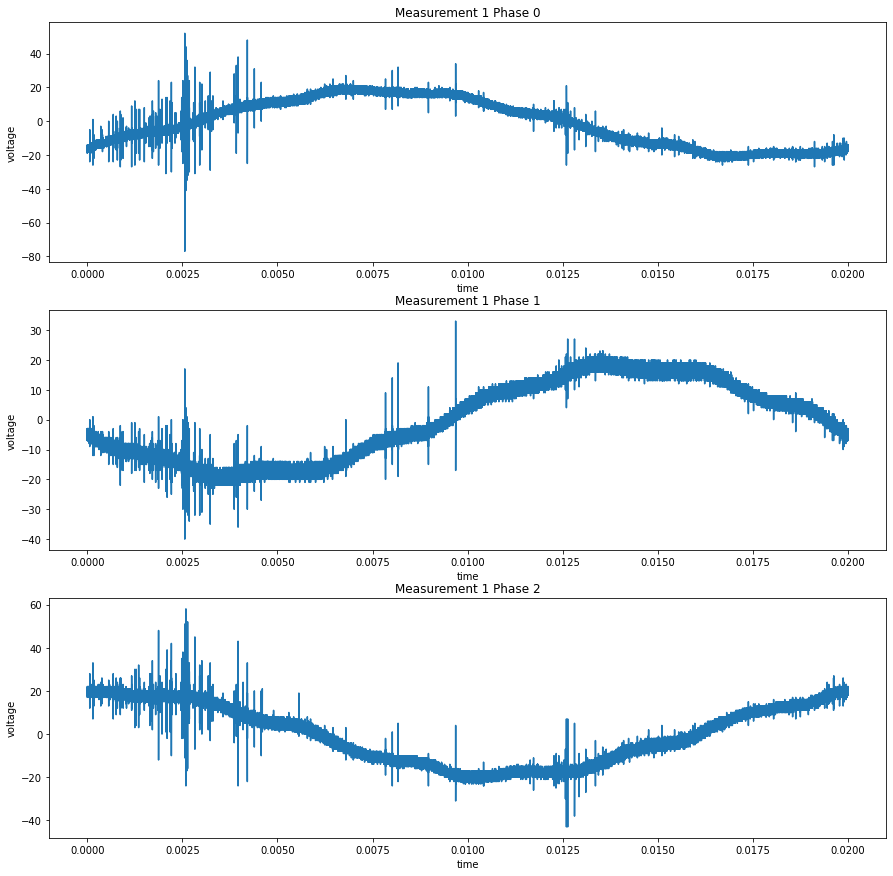

In [46]:
t = np.arange(0, 800000) * (1 / Fs)
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for i in range(0, 3):
    ax[i].plot(t, subset_train.iloc[:, i + 3].values)
    ax[i].set_xlabel("time")
    ax[i].set_ylabel("voltage")
    phase = train_meta.loc[i + 3, "phase"]
    measure_id = train_meta.loc[i + 3, "id_measurement"]
    ax[i].set_title(f"Measurement {measure_id} Phase {phase}")

Measurement 0 has no fault, measurement 1 has a fault.

In [48]:
train_meta.columns

Index(['signal_id', 'id_measurement', 'phase', 'target'], dtype='object')

In [52]:
# getting an idea of how many measurements have faults on more than 1 phase
train_meta.groupby("id_measurement").sum()["target"].value_counts()

0    2710
3     156
1      19
2      19
Name: target, dtype: int64

In [53]:
# class imbalance
train_meta.target.sum() / train_meta.shape[0]

0.060261707988980714